# ZFNet

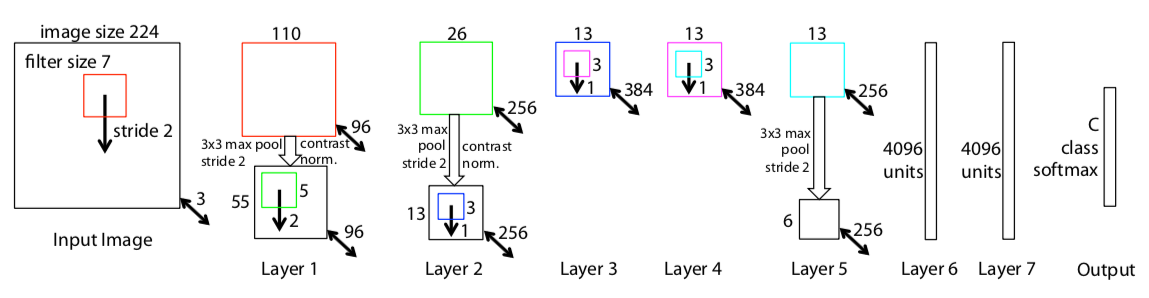

In [ ]:
import os.path
import pickle
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

In [ ]:
class CIFAR10Dataset(Dataset):
    base_folder = 'cifar-10-batches-py'
    train_list = ['data_batch_' + str(i+1) for i in range(5)]
    test_list = ['test_batch',]
    meta = 'batches.meta'
    
    def __init__(
        self,
        root = './',
        train = True,
        transform = None,
        target_transform = None,
    ):
        super().__init__()
        self.root = root
        self.train = train  # training set or test set
        self.transform = transform
        self.target_transform = target_transform
        if self.train:
            file_list = self.train_list
        else:
            file_list = self.test_list
        self.data = []
        self.targets = []
        
        for file_name in file_list:
            file_path = os.path.join(root, self.base_folder, file_name)
            with open(file_path, "rb") as f:
                entry = pickle.load(f, encoding='bytes')
                self.data.append(entry[b'data'])
                self.targets.extend(entry[b'labels'])
        
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC(Height, Width, Channel) 
        
        meta_path = os.path.join(self.root, self.base_folder, self.meta)
        with open(meta_path, "rb") as f:
            label = pickle.load(f, encoding='bytes')
            self.classes = [_class.decode('utf-8') for _class in label[b'label_names']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        # return a PIL Image
        img = Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target
    
    def __len__(self):
        return len(self.data)

In [ ]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 256

trainset = CIFAR10Dataset(root='./', train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Dataset(root='./', train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes =trainset.classes

In [ ]:
class AlexNet(nn.Module):
    in_channels = 3
    conv_kernel = 5
    pool_kernel = 2
    num_classes = 10
    def __init__(self):
        super(AlexNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        dropout = 0.5
        self.gpu1 = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.gpu2 = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, self.num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_gpu1 = self.gpu1(x)
        x_gpu2 = self.gpu2(x)
        x = torch.cat((x_gpu1,x_gpu2),1)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


alexnet = AlexNet()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
alexnet.to(device)